In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [3]:
data_train = pd.read_csv('Training_wells.csv')
data_test = pd.read_csv('Empty_part.csv')

In [4]:
data_train.head()

,Well,X,Y,NTG
0,201-907,201,907,0.2006
1,201-914,201,914,0.3624
2,201-924,201,924,0.4381
3,202-922,202,922,0.4289
4,202-925,202,925,0.4021


In [14]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Well    138 non-null    object 
 1   X       138 non-null    int64  
 2   Y       138 non-null    int64  
 3   NTG     138 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.4+ KB


In [5]:
data_test.head()

,Well,X,Y
0,201-901,201,901
1,201-902,201,902
2,201-903,201,903
3,201-904,201,904
4,201-905,201,905


In [15]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Well    1242 non-null   object
 1   X       1242 non-null   int64 
 2   Y       1242 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 29.2+ KB


# Рассмотрим графики признаков и целевых переменных в обучающем и тестовом наборах данных

<AxesSubplot:>

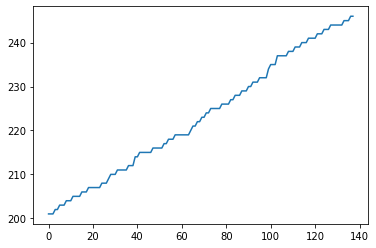

In [6]:
data_train.X.plot()

<AxesSubplot:>

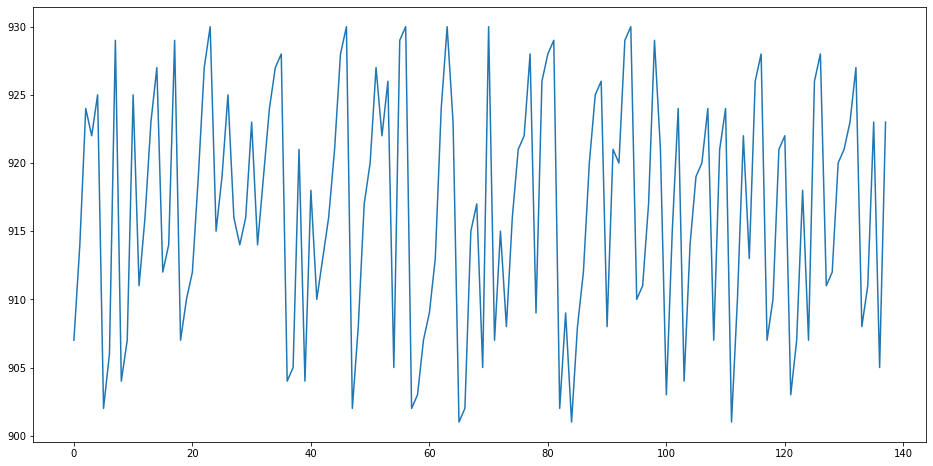

In [8]:
plt.figure(figsize=(16, 8))
data_train.Y.plot()

<AxesSubplot:>

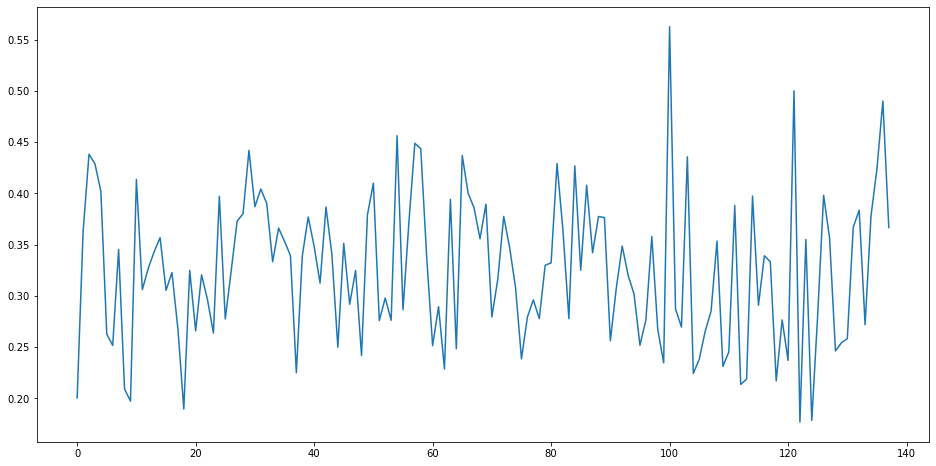

In [10]:
plt.figure(figsize=(16, 8))
data_train.NTG.plot()

<AxesSubplot:>

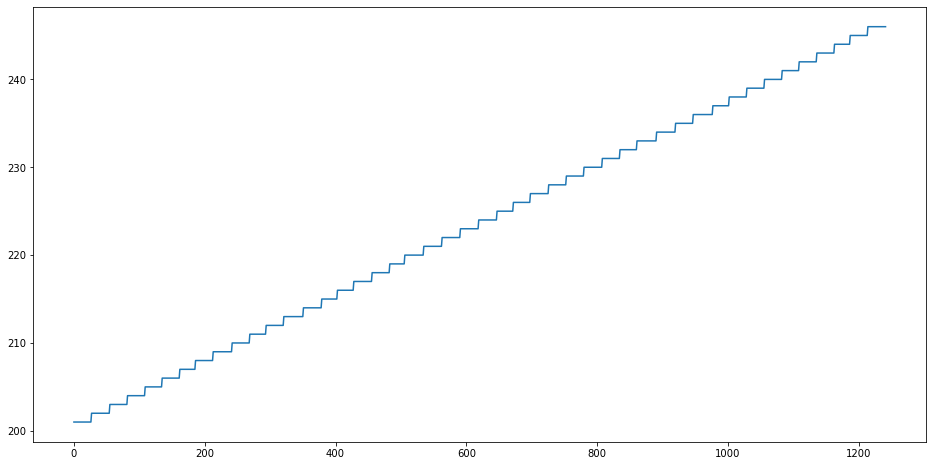

In [11]:
plt.figure(figsize=(16, 8))
data_test.X.plot()

<AxesSubplot:>

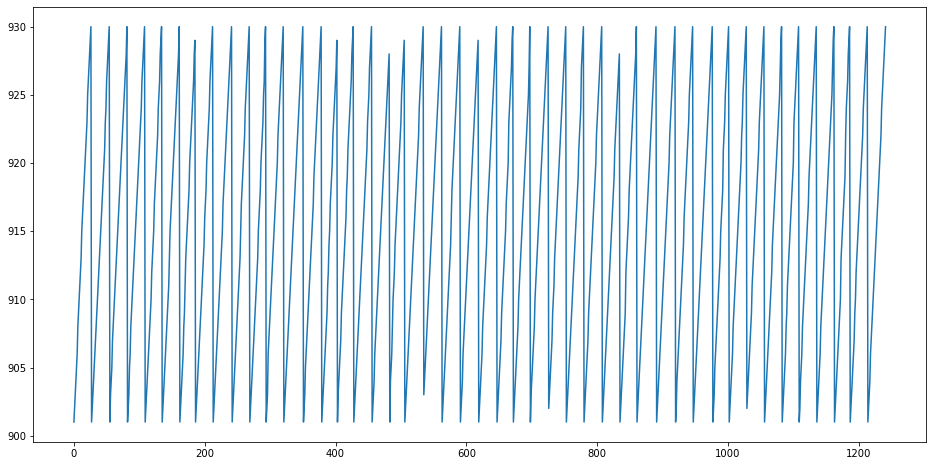

In [12]:
plt.figure(figsize=(16, 8))
data_test.Y.plot()

# Линейная регрессия

Используется ноутбук
https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/seminars/sem02-sklearn-linregr.ipynb

Создадим отдельный датасет для обучения, без лишнего признака Well (id скважины)

In [73]:
train = data_train[['X', 'Y', 'NTG']]
train

,X,Y,NTG
0,201,907,0.2006
1,201,914,0.3624
2,201,924,0.4381
3,202,922,0.4289
4,202,925,0.4021
...,...,...,...
133,245,908,0.2719
134,245,911,0.3780
135,245,923,0.4239
136,246,905,0.4900


Разделим выборку на обучающую и тестовую, также отделим таргет

In [74]:
from sklearn.model_selection import train_test_split

y = train['NTG']
X = train[['X', 'Y']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

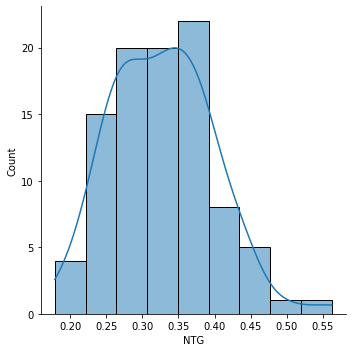

In [75]:
sns.displot(y_train, kde='True')

Так как мы строим линейную регрессию и нам хотелось бы найти "наиболее линейно" связанные признаки, то рассмотрим коэффициент корреляции Пирсона между признаками и "таргетом".

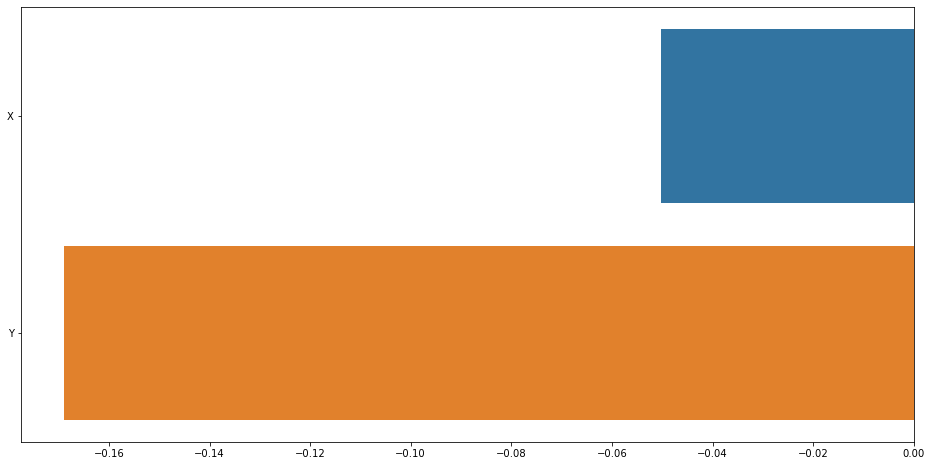

In [76]:
correlations = X_train.corrwith(y_train, method='spearman').sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(16, 8)

Как видим, корреляция практически отсутсвует для X, для Y корреляция также незначительная,хоть и отрицательная.
Рассмотрим графики целевой переменной от каждого признака

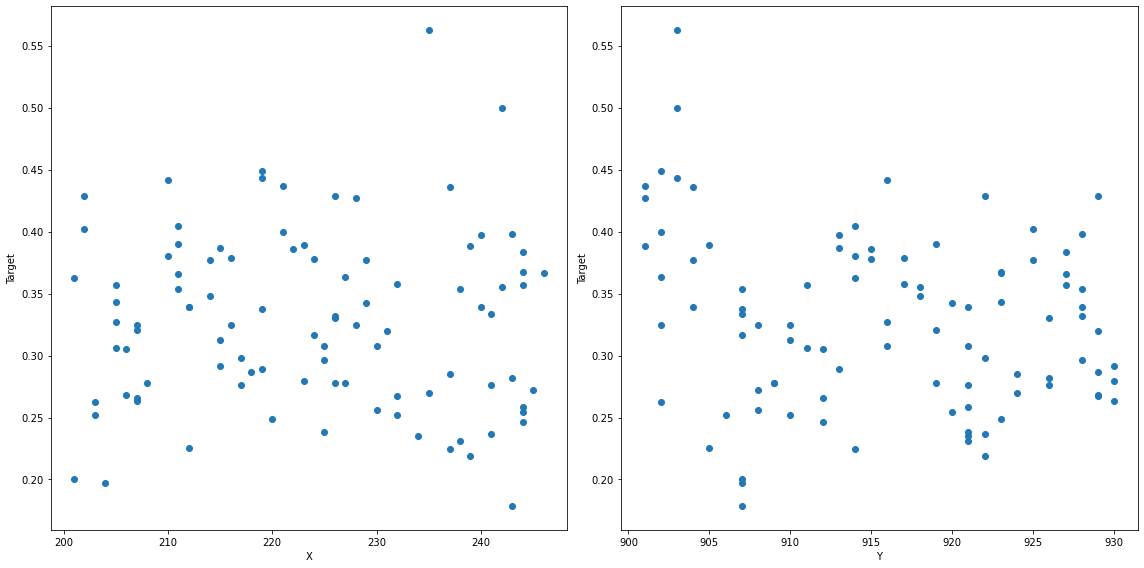

In [77]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=2)
for i, feature in enumerate(['X', 'Y']):
    axs[i].scatter(X_train[feature], y_train, alpha=0.99)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Target')
plt.tight_layout()

Видим, что между признаками и целевой переменной нет никакой линейной зависимости (возможно есть синусоидальная?)

# Перейдем к прогнозированию целевой переменной с применением библиотеки sklearn

In [78]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print('Test MSE = %.4f' % mean_squared_error(y_test, y_pred, squared=False))
print('Train MSE = %.4f' % mean_squared_error(y_train, y_train_pred, squared=False))

Test MSE = 0.0802
Train MSE = 0.0685


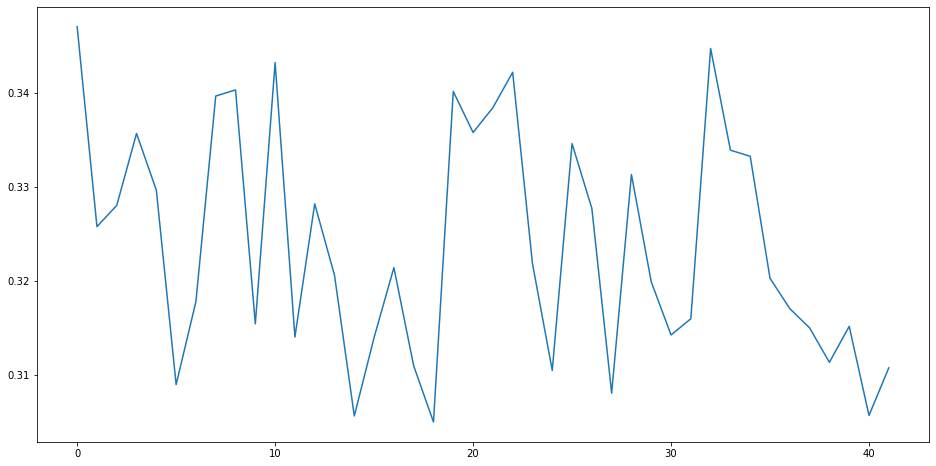

In [79]:
plt.figure(figsize=(16,8))
plt.plot(y_pred, label='preds')

# Попробуем воспользоваться кросс-валидацией

In [80]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -0.0654
	-0.0840
	-0.0641
	-0.0743
	-0.0669
Mean CV MSE = 0.0709


In [81]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

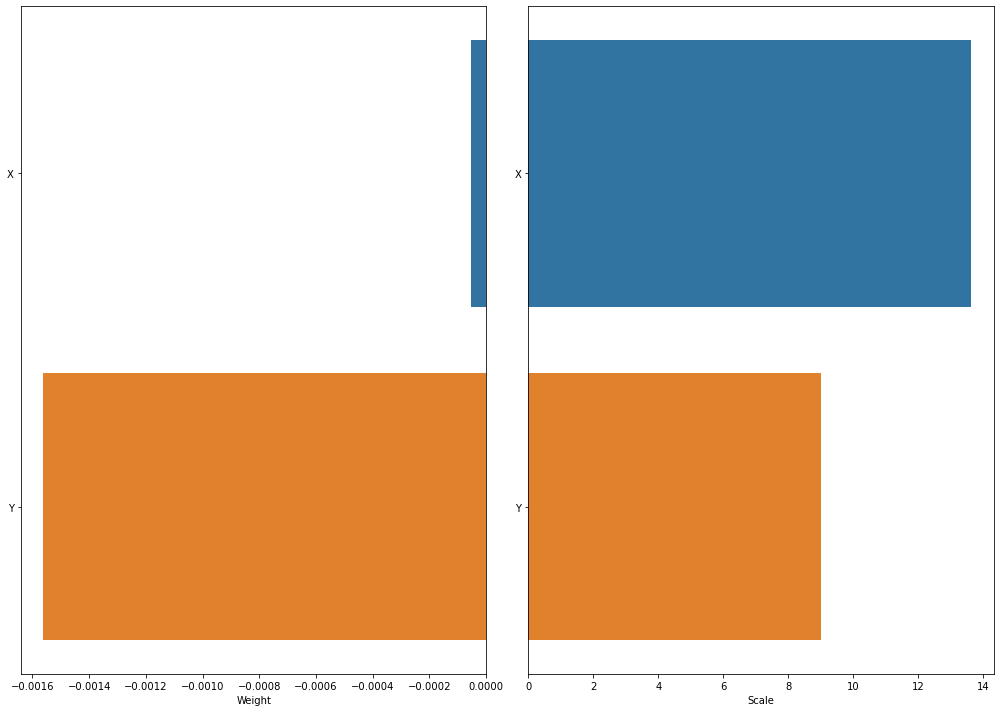

In [69]:
show_weights(['X', 'Y'], model.coef_, X_train.std())

In [82]:
model.coef_

array([-5.38094154e-05, -1.56203048e-03])

# Применим масштабирование признаков

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print('Test RMSE = %.4f' % mean_squared_error(y_test, y_pred, squared = False))
print('Train RMSE = %.4f' % mean_squared_error(y_train, y_train_pred, squared = False))

Test RMSE = 0.0801
Train RMSE = 0.0685


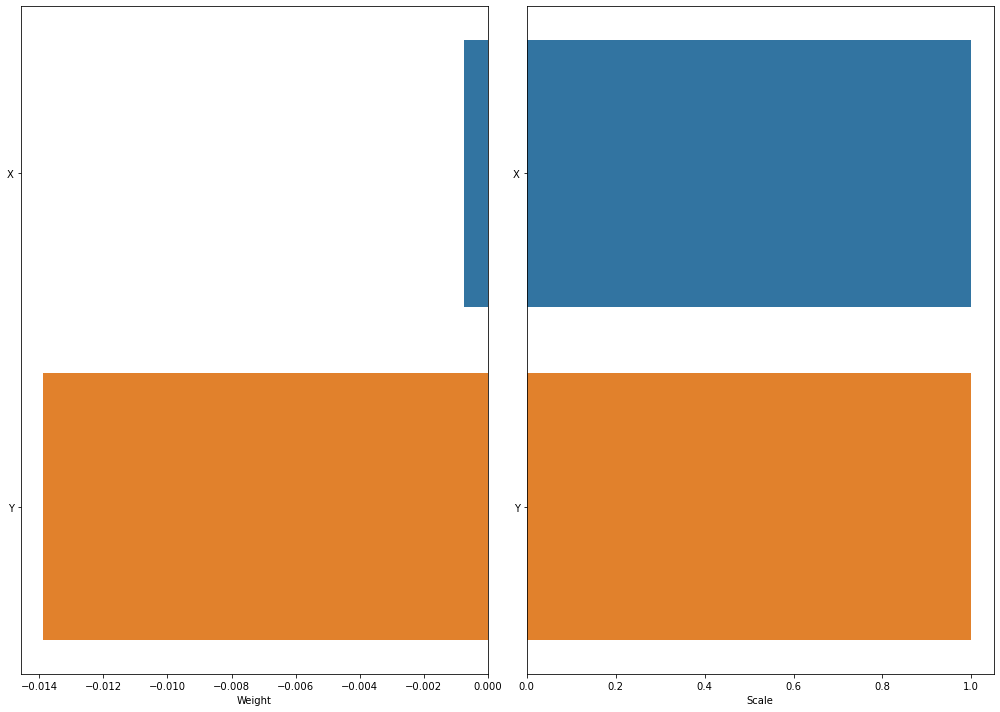

In [84]:
scales = pd.Series(data = X_train_scaled.std(axis=0), index = ['X', 'Y'])
show_weights(['X', 'Y'], model.coef_, scales)

Best alpha = 1000.0000


Text(0, 0.5, 'CV score')

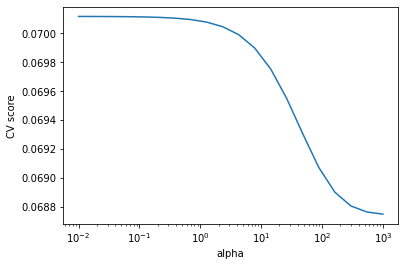

In [88]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{'alpha': alphas}], 
                        scoring='neg_root_mean_squared_error', cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_['alpha']
print('Best alpha = %.4f' % best_alpha)

plt.plot(alphas, -searcher.cv_results_['mean_test_score'])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('CV score')

# Обучим модель с подобранным коэффициентом регуляризации, также распишем Pipeline модели

In [89]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Test RMSE = %.4f' % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.0773


# Спрогнозируем значения для тестовой выборки для загрузки на Контест

In [91]:
test = data_test[['X', 'Y']]

In [92]:
y_test_pred = model.predict(test)

In [95]:
y_test_pred = pd.DataFrame(y_test_pred, columns=['NTG'])

In [96]:
y_test_pred

,NTG
0,0.329622
1,0.329485
2,0.329348
3,0.329211
4,0.329074
...,...
1237,0.325791
1238,0.325654
1239,0.325517
1240,0.325379


<AxesSubplot:>

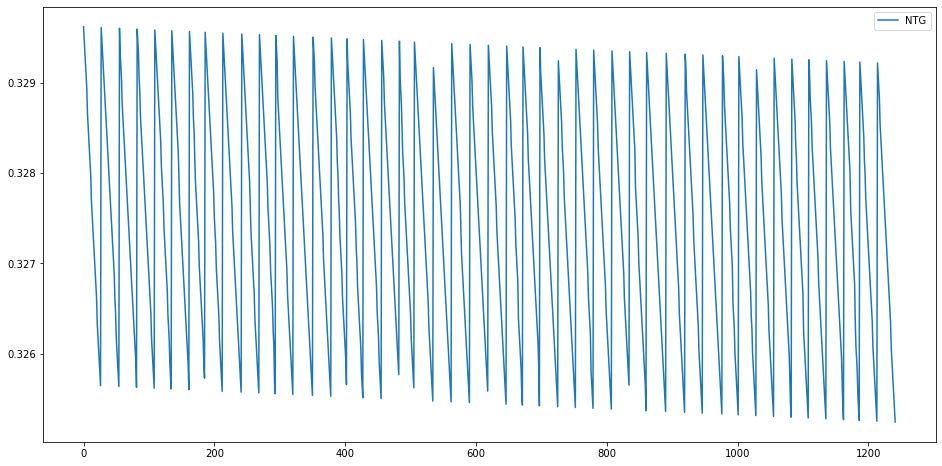

In [97]:
y_test_pred.plot(figsize=(16, 8))